# Custom Transformer

Es una clase de scikit-learn que permite aplicar una función de transformación arbitraria a tus datos. Es útil cuando quieres integrar transformaciones personalizadas dentro de un pipeline.

np.log: transforma los datos aplicando el logaritmo natural.

inverse_func=np.exp: es la función inversa, en este caso la exponencial.

Esto es útil cuando deseas invertir la transformación más adelante, como cuando haces predicciones.



In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import FunctionTransformer

housing = pd.read_csv(Path("../datasets/housing/housing.csv"))


log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_pop

,population
0,5.774552
1,7.783641
2,6.206576
3,6.324359
4,6.336826
...,...
20635,6.739337
20636,5.874931
20637,6.914731
20638,6.608001


🔹 ¿Por qué usar inverse_func?
Cuando transformas tu target (por ejemplo usando np.log) antes de entrenar un modelo, es necesario aplicar la función inversa (en este caso np.exp) para devolver las predicciones a la escala original. De lo contrario, tus resultados no tendrán sentido.

MSE significa Mean Squared Error o Error Cuadrático Medio.

🔍 ¿Qué mide?
Mide cuánto se equivocó el modelo en promedio, pero elevando los errores al cuadrado (para penalizar los errores grandes).

Interpretación:
Mientras más bajo el MSE, mejor.

En este caso, el modelo tiene un MSE de 2.34, lo que significa que las predicciones se desvían, en promedio, unos 1.53 (√2.34) del valor real, considerando que estamos prediciendo ingresos medios (entre 1 y 5).

R2 Score: -0.7888...
R² (coeficiente de determinación) mide qué tan bien el modelo explica la variabilidad del target.

Interpretación:
R² = 1 → predicción perfecta.

R² = 0 → el modelo no explica nada (igual que predecir la media).

R² < 0 → el modelo es peor que predecir simplemente la media del target.

Tu modelo tiene:

MSE = 2.34 → errores relativamente grandes.

R² = -0.78 → el modelo está rindiendo mal; predice peor que simplemente decir "todos ganan el promedio".



MSE: 2.3440986173519103
R2 Score: -0.7888297899932288


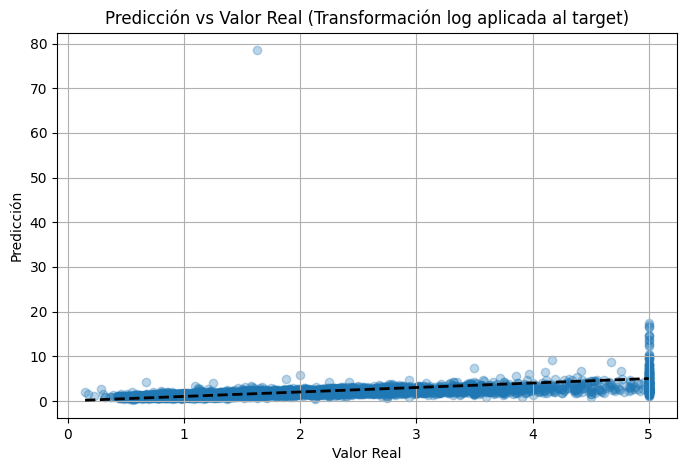

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer

# 1. Cargar datos
data = fetch_california_housing()
X = data.data
y = data.target  # Ingresos medios por bloque en cientos de miles de USD

# 2. Separar en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Crear el transformador logarítmico
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

# 4. Crear el modelo con TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=log_transformer
)

# 5. Entrenar el modelo
model.fit(X_train, y_train)

# 6. Predecir en test (la predicción ya aplica exp automáticamente)
y_pred = model.predict(X_test)

# 7. Validación
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# 8. Graficar predicciones vs reales
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Predicción vs Valor Real (Transformación log aplicada al target)')
plt.grid(True)
plt.show()

Custom Transformer with hyper parameters

Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF)—any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. For example, the Gaussian RBF similarity between the housing age x and 35 is given by the equation exp(–γ(x – 35)²). The hyperparameter γ (gamma) determines how quickly the similarity measure decays as x moves away from 35. Using Scikit-Learn’s rbf_kernel() function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

Ese código que compartiste está utilizando FunctionTransformer para aplicar una función de kernel RBF (Radial Basis Function), que se usa mucho en Machine Learning para medir similitud entre puntos.

Es una función que mide qué tan similar es un dato x respecto a un centro y, usando la fórmula:

RBF(x,y)=exp(−γ∥x−y∥^2)

γ: controla qué tan rápido cae la similitud (más alto → más sensible).
El resultado siempre está entre 0 y 1.
x=y → similitud = 1 (máxima).
Si x está lejos de y → similitud ≈ 0.

Note that there’s no inverse function for the RBF kernel, since there are always two values at a given distance from a fixed point (except at distance 0). Also note that rbf_kernel() does not treat the features separately. If you pass it an array with two features, it will measure the 2D distance (Euclidean) to measure similarity. For example, here’s how to add a feature that will measure the geographic similarity between each district and San Francisco:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


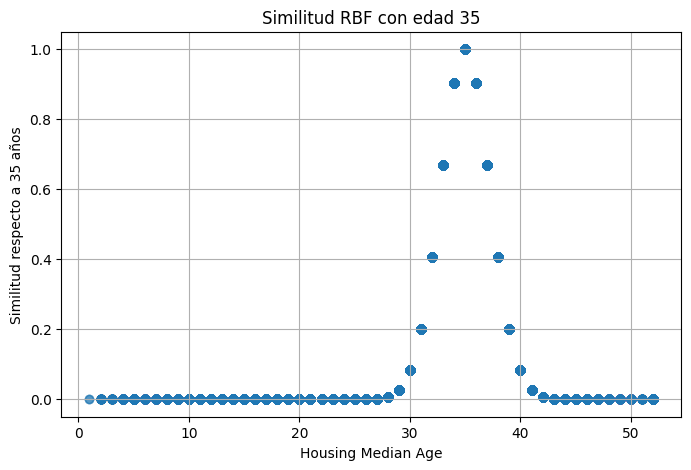

In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import pandas as pd

# Cargar dataset
data = fetch_california_housing()
housing = pd.DataFrame(data.data, columns=data.feature_names)
housing.info()

# Crear transformador RBF con centro en 35 años
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))

# Transformar la columna "housing_median_age"
age_simil_35 = rbf_transformer.transform(housing[["HouseAge"]])  # Cambia por "housing_median_age" si aparece así

# Agregar al DataFrame
housing["simil_to_35"] = age_simil_35

# Graficar la similitud vs edad
plt.figure(figsize=(8, 5))
plt.scatter(housing["HouseAge"], housing["simil_to_35"], alpha=0.3)
plt.xlabel("Housing Median Age")
plt.ylabel("Similitud respecto a 35 años")
plt.title("Similitud RBF con edad 35")
plt.grid(True)
plt.show()

In [ ]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["Latitude", "Longitude"]])
sf_simil

array([[0.99566482],
       [0.99567518],
       [0.99655196],
       ...,
       [0.6599801 ],
       [0.6752005 ],
       [0.67616077]], shape=(20640, 1))

Es una forma simple de crear transformaciones personalizadas en Scikit-Learn usando una función Python cualquiera (como lambda o def).

Te permite convertir cualquier función en un transformador compatible con Pipeline, ColumnTransformer, etc.

Paso a paso:
X[:, [0]]: selecciona la primera columna → [1.], [3.]

X[:, [1]]: selecciona la segunda columna → [2.], [4.]

In [ ]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Creamos el transformador
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

# Aplicamos a una matriz de ejemplo
X = np.array([[1., 2.], [3., 4.]])
result = ratio_transformer.transform(X)
print(result)

FunctionTransformer is very handy, but what if you would like your transformer to be trainable, learning some parameters in the fit() method and using them later in the transform() method? For this, you need to write a custom class. Scikit-Learn relies on duck typing, so this class does not have to inherit from any particular base class. All it needs is three methods: fit() (which must return self), transform(), and fit_transform().

You can get fit_transform() for free by simply adding TransformerMixin as a base class: the default implementation will just call fit() and then transform(). If you add BaseEstimator as a base class (and avoid using *args and **kwargs in your constructor), you will also get two extra methods: get_params() and set_params(). These will be useful for automatic hyperparameter tuning.

For example, here’s a custom transformer that acts much like the StandardScaler:

Here are a few things to note:

The sklearn.utils.validation package contains several functions we can use to validate the inputs. For simplicity, we will skip such tests in the rest of this book, but production code should have them.

Scikit-Learn pipelines require the fit() method to have two arguments X and y, which is why we need the y=None argument even though we don’t use y.

All Scikit-Learn estimators set n_features_in_ in the fit() method, and they ensure that the data passed to transform() or predict() has this number of features.

The fit() method must return self.

This implementation is not 100% complete: all estimators should set feature_names_in_ in the fit() method when they are passed a DataFrame. Moreover, all transformers should provide a get_feature_names_out() method, as well as an inverse_transform() method when their transformation can be reversed. See the last exercise at the end of this chapter for more details.

** check_array(X) **
 - Se usa para validar los datos de entrada X antes de trabajar con ellos.
 - Asegura que X sea un array tipo NumPy (o compatible, como un DataFrame).
 - Se asegura de que no tenga valores NaN o infinitos, a menos que lo permitas explícitamente.

 ¿Por qué es útil? Evita errores raros más adelante y asegura que tu función esté trabajando con datos válidos.


** check_is_fitted(self) **

Se usa para verificar que el transformador o estimador ya haya sido entrenado (fit()) antes de aplicar transform() o predict().

 - Busca atributos que hayan sido "aprendidos" en fit(), como self.mean_, self.scale_, etc.
 - Lanza un error si no encuentra esos atributos con sufijo _, lo que indica que el objeto no fue ajustado (fit) correctamente.

¿Por qué es útil? Previene que alguien use .transform() sin haber llamado primero a .fit(), lo que causaría errores porque los atributos necesarios (mean_, scale_) no existen todavía.

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

🧠 ¿Qué es KMeans clustering?
KMeans es un algoritmo de clustering no supervisado. Su propósito es agrupar tus datos en K grupos (clusters) basados en la proximidad entre ellos (usualmente usando la distancia euclidiana).

🔍 ¿Cómo funciona?
Eliges el número de clusters K (por ejemplo, 3).

Se inicializan aleatoriamente K puntos (centroides).

Cada punto de tus datos es asignado al centro más cercano.

Se actualizan los centros (el promedio de los puntos en cada cluster).

Se repite hasta que no cambian los clusters (o se alcanza un máximo de iteraciones).

🎯 ¿Qué hace el transformador ClusterSimilarity?
Ahora combinamos eso con una idea muy interesante: en lugar de solo agrupar, queremos usar los clusters como referencias, y medir qué tan parecido es cada punto a cada centro de cluster.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

A custom transformer can (and often does) use other estimators in its implementation. For example, the following code demonstrates custom transformer that uses a KMeans clusterer in the fit() method to identify the main clusters in the training data, and then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarityKMean(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]